# <center><b>Practice 3.2</b>: KMeans Image Segmentation</center>

## 1. Import Libraty

In [30]:
import cv2  # Đọc ảnh
import numpy as np
import matplotlib.pyplot as plt

from skimage import data    # Lấy hình ảnh

In [31]:
# KMean được lấy từ Practice 3.1

class KMeansScratch:
    def __init__(self, n_clusters=3, max_iter=300, tol=1e-4, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
        self.centroids = None
       	self.labels_ = None
        self.inertia_ = None

    def _init_centroids(self, X):
        """Khởi tạo centroids bằng cách chọn ngẫu nhiên k điểm."""
        np.random.seed(self.random_state)
        idx = np.random.choice(len(X), self.n_clusters, replace=False)
        return X[idx]

    def _compute_distances(self, X, centroids):
        """Tính khoảng cách Euclidean từ từng điểm đến từng centroid."""
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            distances[:, k] = np.linalg.norm(X - centroids[k], axis=1)
        return distances

    def _compute_inertia(self, X, labels):
        """Tính tổng bình phương khoảng cách (inertia)."""
        inertia = 0.0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - self.centroids[k]) ** 2)
        return inertia

    def fit(self, X):
        """Huấn luyện mô hình K-Means."""
        X = np.array(X)
        self.centroids = self._init_centroids(X)

        for _ in range(self.max_iter):
            # Gán cụm
            distances = self._compute_distances(X, self.centroids)
            labels = np.argmin(distances, axis=1)

            # Tính centroid mới
            new_centroids = np.array([
                X[labels == k].mean(axis=0) if np.any(labels == k)
                else self.centroids[k]   # tránh empty cluster
                for k in range(self.n_clusters)
            ])

            # Kiểm tra hội tụ
            shift = np.linalg.norm(new_centroids - self.centroids)

            self.centroids = new_centroids
            self.labels_ = labels

            if shift < self.tol:
                break

        # Tính inertia
        self.inertia_ = self._compute_inertia(X, self.labels_)

    def predict(self, X):
        """Dự đoán cụm cho dữ liệu mới."""
        X = np.array(X)
        distances = self._compute_distances(X, self.centroids)
        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        """Huấn luyện và trả về luôn nhãn cụm."""
        self.fit(X)
        return self.labels_

---

## 2. LOAD & PREPROCESS IMAGE

In [32]:
# Tải 1 ảnh mẫu (sử dụng ảnh 'chelsea' - con mèo)
# Kích thước gốc: (300, 451, 3)
image_rgb = data.chelsea()  

# Resize ảnh về kích thước nhỏ hơn để tính toán nhanh hơn
# Kích thước: (300, 300, 3)
image_small = cv2.resize(image_rgb, (300, 300))

In [33]:
# Chuyển từ không gian màu RGB sang LAB
# LAB giúp K-Means phân cụm dựa trên màu sắc tốt hơn (tách biệt độ sáng L)
image_lab = cv2.cvtColor(image_small, cv2.COLOR_RGB2LAB)

Kích thước ảnh gốc (sau resize): 300x300x3
Kích thước tập dữ liệu pixel (flatten): (90000, 3)


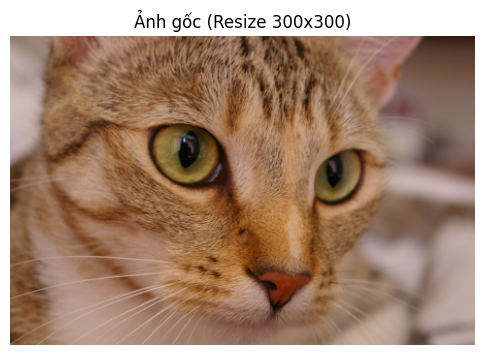

In [34]:
# Flatten (Làm phẳng): Chuyển từ (H, W, C) -> (H*W, C)
# Mỗi pixel (L, A, B) giờ là một "điểm dữ liệu" 3 chiều
H, W, C = image_lab.shape
pixels = image_lab.reshape(-1, C)

print(f"Kích thước ảnh gốc (sau resize): {H}x{W}x{C}")
print(f"Kích thước tập dữ liệu pixel (flatten): {pixels.shape}")

# Hiển thị ảnh gốc sau khi resize và chuyển sang LAB (trước khi phân đoạn)
plt.figure(figsize=(6,6))
plt.imshow(image_rgb)
plt.title("Ảnh gốc (Resize 300x300)")
plt.axis("off")
plt.show()

---

## 3. SELECT OPTIMAL K (ELBOW METHOD)

In [35]:
# Tính toán WSS (Inertia) cho nhiều giá trị K
wss = []
max_k = 10
# Thử K từ 1 đến max_k-1 (vì K=10 sẽ là max_k)
K_values = range(1, max_k)

for k in K_values:
    # Bỏ qua cảnh báo 'n_init' nếu có
    kmeans = KMeansScratch(n_clusters=k, random_state=42) 
    kmeans.fit(pixels)
    wss.append(kmeans.inertia_)

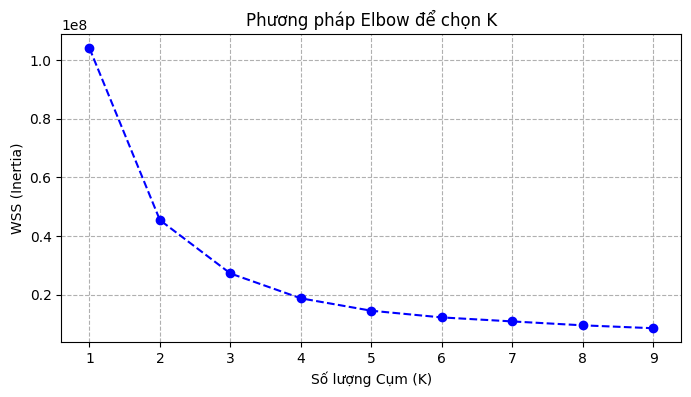

In [36]:
# Hiển thị biểu đồ Elbow
plt.figure(figsize=(8, 4))
plt.plot(K_values, wss, marker='o', linestyle='--', color='b')
plt.title('Phương pháp Elbow để chọn K')
plt.xlabel('Số lượng Cụm (K)')
plt.ylabel('WSS (Inertia)')
plt.grid(True, linestyle='--')
plt.xticks(K_values)
plt.show()

Sau khi xem biểu đồ Elbow, hãy chọn K tối ưu (nơi độ dốc giảm chậm lại).   
Trong trường hợp này, K=4 hoặc K=5 có thể là điểm cùi chỏ.

## 4. APPLY K-MEANS AND RECONSTRUCT IMAGE (K=5)

In [ ]:
# Chọn K = 5 (theo kết quả phân tích Elbow)
K_OPTIMAL = 5 

kmeans = KMeansScratch(
    n_clusters=K_OPTIMAL,
    random_state=42
)

# Huấn luyện mô hình K-Means trên tập pixel
kmeans.fit(pixels)

# Lấy nhãn (label) và tâm cụm (centroid)
labels = kmeans.labels_        # Nhãn cụm của từng pixel
centroids = kmeans.centroids  # Màu trung bình của từng cụm (K, 3)

print(f"Số lượng Centroids (K, C): {centroids.shape}")

# Tái tạo ảnh segmented: 
# Gán lại cho mỗi pixel màu của tâm cụm mà nó thuộc về
segmented_pixels = centroids[labels]

# Reshape lại về kích thước ảnh ban đầu (H, W, C)
segmented_image_lab = segmented_pixels.reshape(H, W, C)

# Chuyển LAB về RGB để hiển thị (Quan trọng: phải chuyển về np.uint8)
segmented_rgb = cv2.cvtColor(segmented_image_lab.astype(np.uint8), cv2.COLOR_LAB2RGB)

print(f"Ảnh segmented (K={K_OPTIMAL}) đã được tái tạo.")

Số lượng Centroids (K, C): (5, 3)
Ảnh segmented (K=5) đã được tái tạo.


## 5. VISUALIZE RESULTS

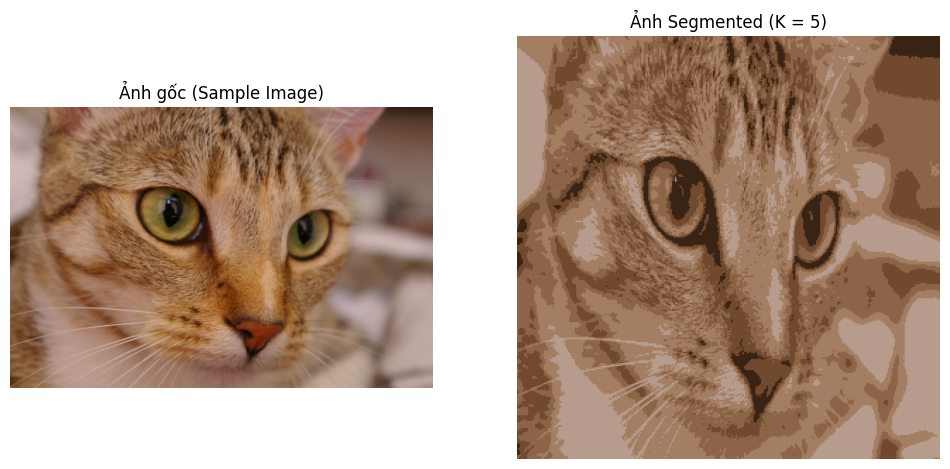

In [ ]:
plt.figure(figsize=(12, 6))

# Ảnh gốc
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Ảnh gốc (Sample Image)")
plt.axis("off")

# Ảnh phân đoạn
plt.subplot(1, 2, 2)
plt.imshow(segmented_rgb)
plt.title(f"Ảnh Segmented (K = {K_OPTIMAL})")
plt.axis("off")
plt.show()